# Part II: Clustering time series

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy.interpolate import splev, interp1d
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [2]:
# converted from R's ns()
def ns(x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3
    
    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    oleft = x < boundary_knots[0]
    oright = x > boundary_knots[1]
    outside = oleft | oright
    inside = ~outside

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0
            
        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x[~outside], knots)

    Aknots = np.sort(np.concatenate((boundary_knots * 4, knots)))
    n_bases = len(Aknots) - (degree + 1)

    if any(outside):
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        e = 1 / 4 # in theory anything in (0, 1); was (implicitly) 0 in R <= 3.2.2

        if any(oleft):
            k_pivot = boundary_knots[0]
            xl = x[oleft] - k_pivot
            xl = np.c_[np.ones(xl.shape[0]), xl]

            # equivalent to splineDesign(Aknots, rep(k.pivot, ord), ord, derivs)
            tt = np.empty((xl.shape[1], n_bases), dtype=float)
            for j in range(xl.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)

            basis[oleft, :] = xl @ tt

        if any(oright):
            k_pivot = boundary_knots[1]
            xr = x[oright] - k_pivot
            xr = np.c_[np.ones(xr.shape[0]), xr]

            tt = np.empty((xr.shape[1], n_bases), dtype=float)
            for j in range(xr.shape[1]):
                for i in range(n_bases):
                    coefs = np.zeros((n_bases,))
                    coefs[i] = 1
                    tt[j, i] = splev(k_pivot, (Aknots, coefs, degree), der=j)
                    
            basis[oright, :] = xr @ tt
        
        if any(inside):
            xi = x[inside]
            tt = np.empty((len(xi), n_bases), dtype=float)
            for i in range(n_bases):
                coefs = np.zeros((n_bases,))
                coefs[i] = 1
                tt[:, i] = splev(xi, (Aknots, coefs, degree))

            basis[inside, :] = tt
    else:
        basis = np.empty((x.shape[0], n_bases), dtype=float)
        for i in range(n_bases):
            coefs = np.zeros((n_bases,))
            coefs[i] = 1
            basis[:, i] = splev(x, (Aknots, coefs, degree))

    const = np.empty((2, n_bases), dtype=float)
    for i in range(n_bases):
        coefs = np.zeros((n_bases,))
        coefs[i] = 1
        const[:, i] = splev(boundary_knots, (Aknots, coefs, degree), der=2)

    if include_intercept is False:
        basis = basis[:, 1:]
        const = const[:, 1:]

    qr_const = np.linalg.qr(const.T, mode='complete')[0]
    basis = (qr_const.T @ basis.T).T[:, 2:]

    return basis
    

In [3]:
def ns_predict(new, x, df=None, knots=None, boundary_knots=None, include_intercept=False):
    degree = 3

    if boundary_knots is None:
        boundary_knots = [np.min(x), np.max(x)]
    else:
        boundary_knots = np.sort(boundary_knots).tolist()

    if df is not None:
        nIknots = df - 1 - include_intercept
        if nIknots < 0:
            nIknots = 0

        if nIknots > 0:
            knots = np.linspace(0, 1, num=nIknots + 2)[1:-1]
            knots = np.quantile(x, knots)

    basis = ns(new, df=df, knots=knots, boundary_knots=boundary_knots,
               include_intercept=include_intercept)

    return basis


In [4]:
data_df = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
data_df = data_df.set_index('Product_Code')
data_df = data_df.iloc[:, :52]
data_df.head()

,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
Product_Code,,,,,,,,,,,,,,,,,,,,,
P1,11,12,10,8,13,12,14,21,6,14,...,4,7,8,10,12,3,7,6,5,10
P2,7,6,3,2,7,1,6,3,3,3,...,2,4,5,1,1,4,5,1,6,0
P3,7,11,8,9,10,8,7,13,12,6,...,6,14,5,5,7,8,14,8,8,7
P4,12,8,13,5,9,6,9,13,13,11,...,9,10,3,4,6,8,14,8,7,8
P5,8,5,13,11,6,7,9,14,9,9,...,7,11,7,12,6,6,5,11,8,9


In [7]:
X = data_df.to_numpy(dtype=np.float16)
X = X - np.mean(X, axis=1, keepdims=True)

## 1. Fitting NCS

In [8]:
n_products = X.shape[0]
n_weeks = X.shape[1]
df = 10
x = np.arange(1, n_weeks+1)
F = ns(x, df=df-1)
F = F - np.mean(F, axis=0, keepdims=True)
B = np.matmul(np.matmul(np.linalg.inv(np.matmul(F.T, F)), F.T), X.T).T

## 2. Clustering using Matrix B

In [11]:
n_clusters = 6
n_rows = 2
n_cols = 3
B_clusters = KMeans(n_clusters=n_clusters).fit_predict(B)

/Users/hanyan/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


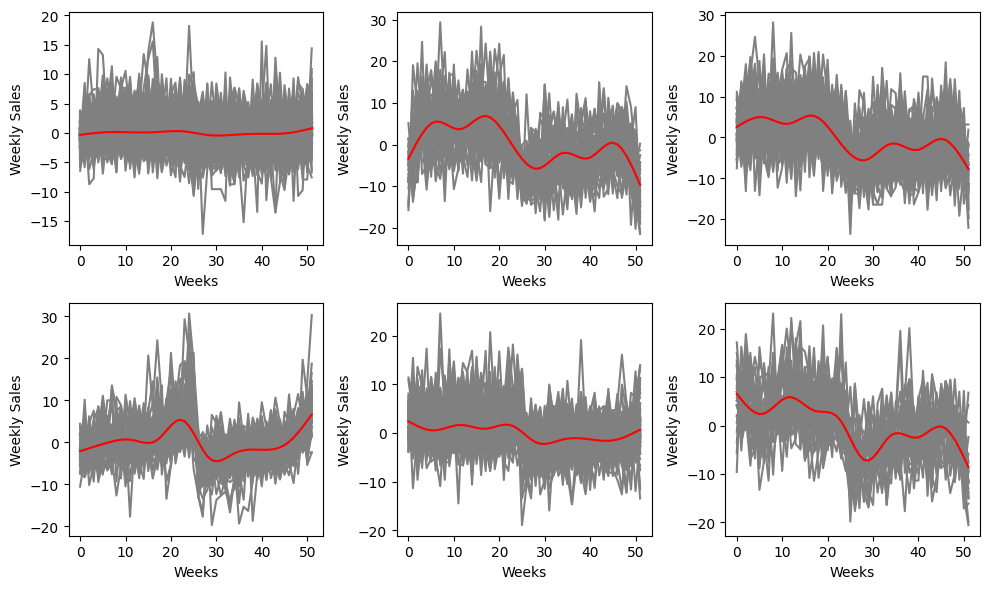

In [12]:
plt.figure(figsize=(10,6))
for i in range(n_clusters):
    mask = B_clusters == i
    plt.subplot(n_rows, n_cols, i+1)
    plt.plot(X[mask].T, color='gray')
    plt.plot(np.matmul(F, np.mean(B[mask], axis=0)), color='red')
    plt.xlabel('Weeks')
    plt.ylabel('Weekly Sales')
plt.tight_layout()

## 3. Clustering using Matrix X

In [22]:
X_clusters = KMeans(n_clusters=n_clusters).fit_predict(X)

/Users/hanyan/miniforge3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


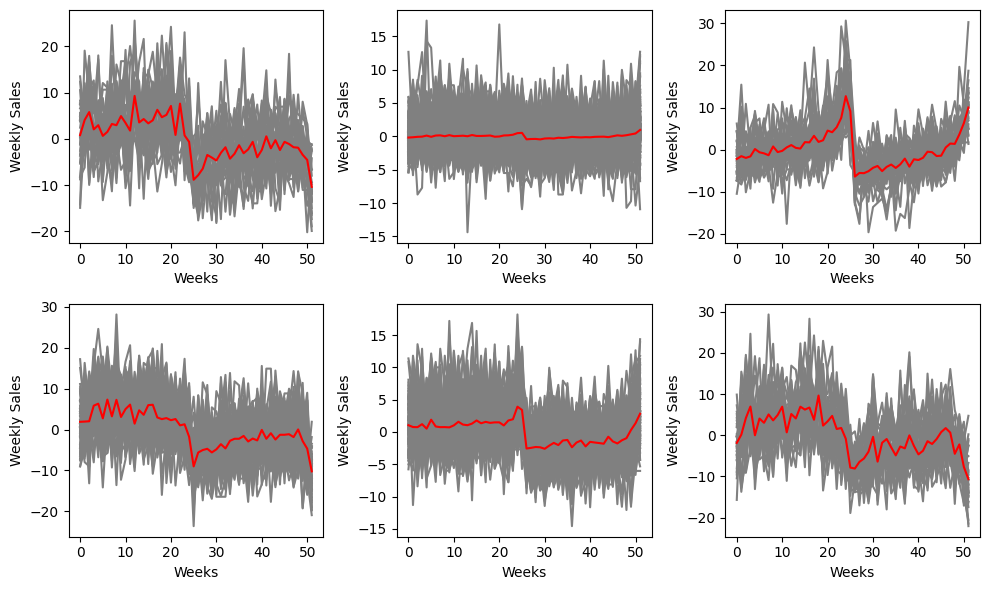

In [23]:
plt.figure(figsize=(10,6))
for i in range(n_clusters):
    mask = X_clusters == i
    plt.subplot(n_rows, n_cols, i+1)
    curr_ts = X[mask]
    plt.plot(curr_ts.T, color='gray')
    plt.plot(np.mean(curr_ts, axis=0), color='red')
    plt.xlabel('Weeks')
    plt.ylabel('Weekly Sales')
plt.tight_layout()